# Face Alignment CW
Rohit Pai 198771

## Standard Imports

In [0]:
# !pip uninstall opencv-python
# !pip uninstall opencv-contrib-python
# !pip install opencv-python==3.4.2.16
# !pip install opencv-contrib-python==3.4.2.16
# !pip install tensorflow
%tensorflow_version 2.x
# !pip install -q --upgrade ipython
# !pip install -q --upgrade ipykernel

In [0]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, MaxPool1D, Conv1D
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading

Download relevent images

In [38]:
!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
# The test images (without points)
!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
# The example images are here
!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz

--2020-05-27 19:29:42--  http://users.sussex.ac.uk/~is321/training_images.npz
Resolving users.sussex.ac.uk (users.sussex.ac.uk)... 139.184.14.119
Connecting to users.sussex.ac.uk (users.sussex.ac.uk)|139.184.14.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375302693 (358M)
Saving to: ‘training_images.npz’

training_images.npz 100%[===================>] 357.92M  25.9MB/s    in 17s     

2020-05-27 19:30:00 (20.8 MB/s) - ‘training_images.npz’ saved [375302693/375302693]

--2020-05-27 19:30:00--  http://users.sussex.ac.uk/~is321/test_images.npz
Resolving users.sussex.ac.uk (users.sussex.ac.uk)... 139.184.14.119
Connecting to users.sussex.ac.uk (users.sussex.ac.uk)|139.184.14.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74915629 (71M)
Saving to: ‘test_images.npz’

test_images.npz     100%[===================>]  71.44M  17.3MB/s    in 6.2s    

2020-05-27 19:30:07 (11.4 MB/s) - ‘test_images.npz’ saved [74915629/74915629]

--2020

In [0]:
# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']



## Data Visualisation
Here's an example of how to display the images and their points

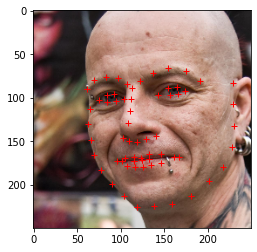

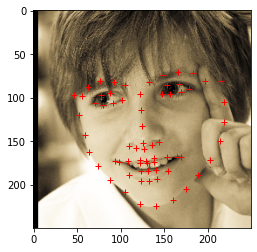

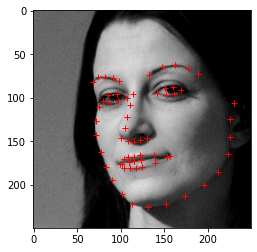

In [40]:
#print(images.shape, pts.shape)
def visualise_pts(img, pts):
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

## Calculating Prediction Error and exporting results

In [0]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [0]:
def save_as_csv(points, location = '.'):
  """
  Save the points out as a .csv file
  :param points: numpy array of shape (no_image, no_points, 2) to be saved
  :param location: Directory to save results.csv in. Default to current working directory
  """
  np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


In [43]:
pts[0].shape

(68, 2)

## Tensorflow model

Define the model layers and compile it

In [44]:
model_layers = [ 
    Conv2D( 64 , input_shape=( 250 , 250 , 3 ) , kernel_size=( 5 , 5 ) , strides=1 , activation='relu'),
    Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(5,5)),

    Conv2D( 96 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu'),
    Conv2D( 96 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu'),
    BatchNormalization(),
    Conv2D( 96 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu'),
    Conv2D( 96 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu'),
    #BatchNormalization(),

    MaxPooling2D(pool_size=(2,2)),

    Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu'),
    Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu'),
    BatchNormalization(),
    Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu'),
    Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu'),
    #BatchNormalization(),

    #BatchNormalization(),
    MaxPooling2D(pool_size=(3,3)),
    Conv2D( 136 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu'),
    Conv2D( 136 , kernel_size=( 2 , 2 ) , strides=1 , activation='sigmoid'),

]
model = Sequential( model_layers )
model.compile(loss='mean_squared_error' , optimizer='adam' , metrics=[ 'accuracy' ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 246, 246, 64)      4864      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 242, 242, 64)      102464    
_________________________________________________________________
batch_normalization_3 (Batch (None, 242, 242, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 46, 46, 96)        55392     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 44, 44, 96)        83040     
_________________________________________________________________
batch_normalization_4 (Batch (None, 44, 44, 96)       

## Fit model

Here we will fit the model with the training images and points. 
Note that the points need to be reshaped to fit the output shape of the model. 
The images and points needs to be normalised too

In [0]:
# points = [-1 + (1 - -1) * x for x in pts]
imgs = images/255.0 #normalize images
points = pts/250 #normalize points
points = np.reshape(points , ( -1 , 1 , 1 , 136 )) #reshape points to the right shape
earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5) #implement early stop so that it doesn't overfit
training = model.fit(images, points, epochs=15, batch_size=50, validation_split=0.3, callbacks=[earlyStop]) #fit model

Epoch 1/15
40/40 [==============================] - 2173s 54s/step - loss: 0.0019 - accuracy: 0.5836 - val_loss: 0.0023 - val_accuracy: 0.5521
Epoch 2/15
40/40 [==============================] - 2181s 55s/step - loss: 0.0017 - accuracy: 0.5740 - val_loss: 0.0030 - val_accuracy: 0.5533
Epoch 3/15
40/40 [==============================] - 2181s 55s/step - loss: 0.0014 - accuracy: 0.5297 - val_loss: 0.0031 - val_accuracy: 0.4313
Epoch 4/15
40/40 [==============================] - 2180s 55s/step - loss: 9.8968e-04 - accuracy: 0.5109 - val_loss: 0.0021 - val_accuracy: 0.5735
Epoch 5/15
40/40 [==============================] - 2181s 55s/step - loss: 7.6048e-04 - accuracy: 0.5536 - val_loss: 0.0017 - val_accuracy: 0.5735
Epoch 6/15
40/40 [==============================] - 2180s 55s/step - loss: 6.7339e-04 - accuracy: 0.5714 - val_loss: 7.6518e-04 - val_accuracy: 0.5770
Epoch 7/15
40/40 [==============================] - 2177s 54s/step - loss: 5.7689e-04 - accuracy: 0.5907 - val_loss: 8.6343e-0

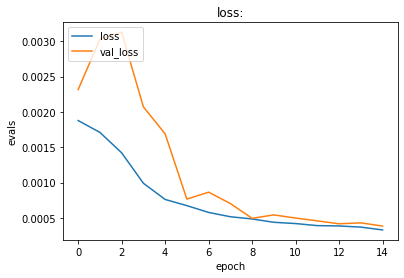

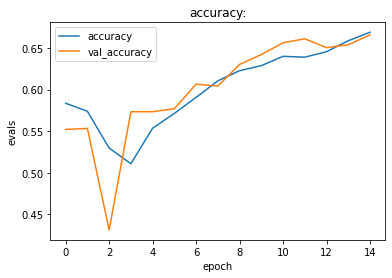

In [0]:
#show model history here
keys = training.history.keys()

#show loss and value loss which is the mean square error
# for key in keys:
plt.plot(training.history["loss"])
plt.plot(training.history["val_loss"])
# plt.ylim([0, 1])
plt.title('loss:')
plt.ylabel('evals')
plt.xlabel('epoch')
plt.legend(["loss", "val_loss"], loc='upper left')
plt.show()

#show the accuracy and value accuracy of model
plt.plot(training.history["accuracy"])
plt.plot(training.history["val_accuracy"])
# plt.ylim([0, 1])
plt.title('accuracy:')
plt.ylabel('evals')
plt.xlabel('epoch')
plt.legend(["accuracy", "val_accuracy"], loc='upper left')
plt.show()

## Predict it

Let's predict using model and see what it gives

(1, 1, 1, 136)


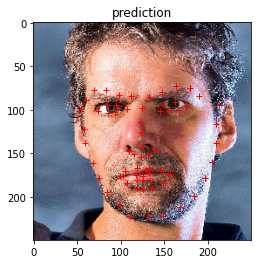

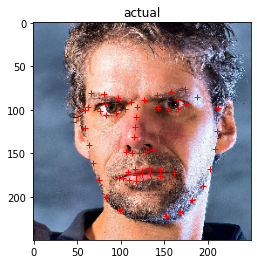

4.807533370959767


In [0]:
# like near perfect
#predict points
pred = model.predict(np.array([images[31]]))
#check the shape if it is right
print(pred.shape)
#unnormalize points
pred = pred * 250
pred = np.reshape(pred, (68,2)) #reshape points back to normal
#show predicted points on image 31
plt.plot(pred[:, 0], pred[:, 1], '+r')
plt.title("prediction")
plt.imshow(images[31])
plt.show()

#show actual image with ground truth points
plt.plot(pts[31, ...][:, 0], pts[31, ...][:, 1], '+r')
plt.title("actual")
plt.imshow(images[31])
plt.show()

#calculate euclidian distance of points
euclidDist = euclid_dist(pred, pts[31])

#grab an average eucldian distance of the points
print(np.mean(euclidDist))

## Some more random predicitons

Let's try out some more random pridictions on the other training data and see how it does

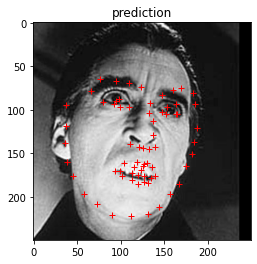

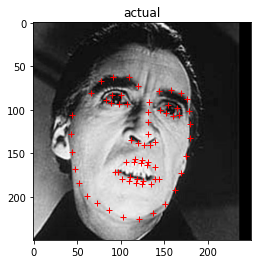

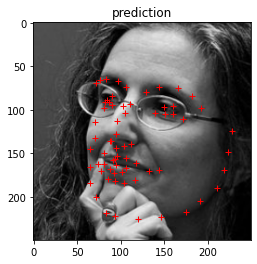

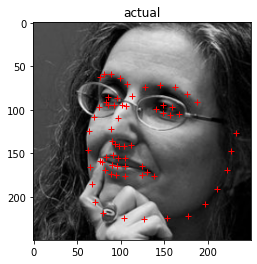

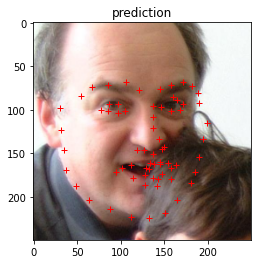

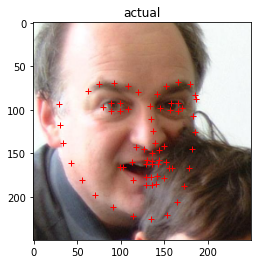

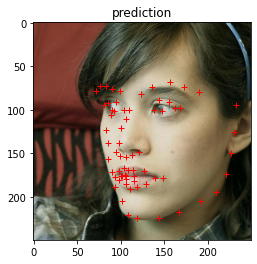

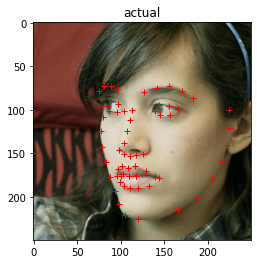

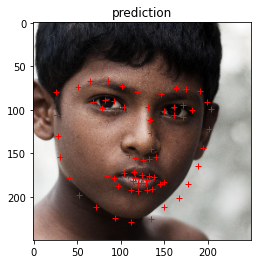

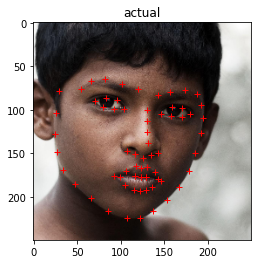

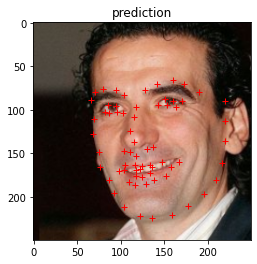

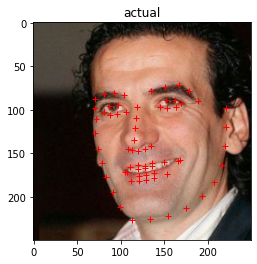

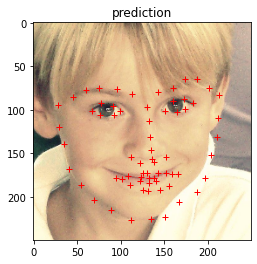

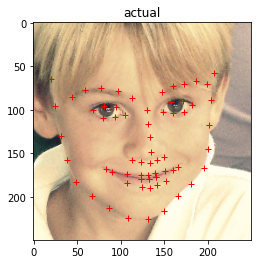

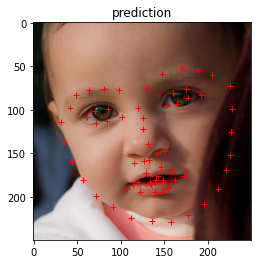

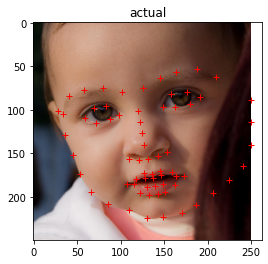

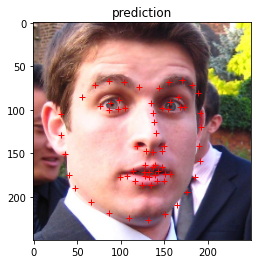

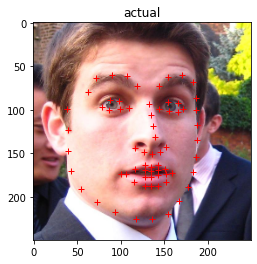

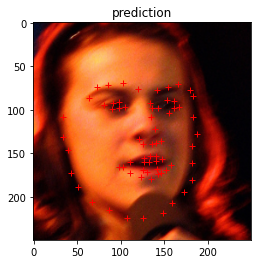

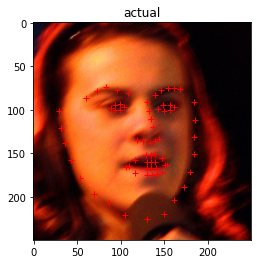

In [0]:
#show random images with the predicted points and ground truth points
for i in range(10):
    #select random number between 0 and 1000
    j = random.randint(0,1000)
    #predict on random image taken from above
    pred = model.predict(np.array([images[j]]))
    pred = pred * 250 #unnormalize iamge
    pred = np.reshape(pred, (68,2)) #reshape image back to original shape
    #plot predicted points on image
    plt.plot(pred[:, 0], pred[:, 1], '+r')
    plt.title("prediction")
    plt.imshow(images[j])
    plt.show()

    #plot the ground truth points on the image
    plt.plot(pts[j, ...][:, 0], pts[j, ...][:, 1], '+r')
    plt.title("actual")
    plt.imshow(images[j])
    plt.show()

## Test it out

Let's load in the testing data and see what it can do on some of those images too 

In [0]:
test = np.load("test_images.npz") #load test images

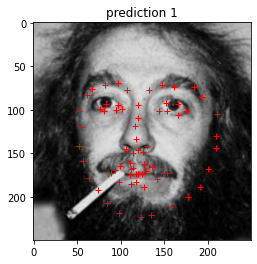

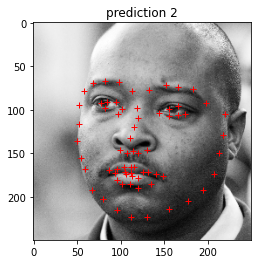

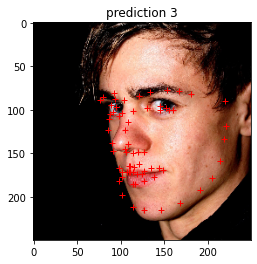

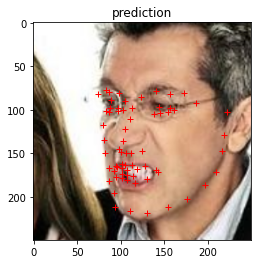

In [57]:
pred = model.predict(np.array([test["images"][30]]))
pred = pred * 250
pred = np.reshape(pred, (68,2))
plt.plot(pred[:, 0], pred[:, 1], '+r')
plt.title("prediction 1")
plt.imshow(test["images"][30])
plt.show()

pred = model.predict(np.array([test["images"][56]]))
pred = pred * 250
pred = np.reshape(pred, (68,2))
plt.plot(pred[:, 0], pred[:, 1], '+r')
plt.title("prediction 2")
plt.imshow(test["images"][56])
plt.show()

pred = model.predict(np.array([test["images"][66]]))
pred = pred * 250
pred = np.reshape(pred, (68,2))
plt.plot(pred[:, 0], pred[:, 1], '+r')
plt.title("prediction 3")
plt.imshow(test["images"][66])
plt.show()


pred = model.predict(np.array([test["images"][97]]))
pred = pred * 250
pred = np.reshape(pred, (68,2))
plt.plot(pred[:, 0], pred[:, 1], '+r')
plt.title("prediction")
plt.imshow(test["images"][97])
plt.show()

## Let'add sunglasses

Let's add sunglasses to an image

(1, 1, 1, 136)


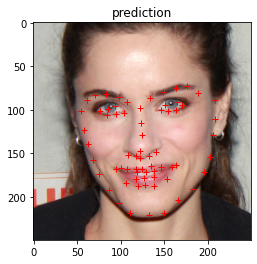

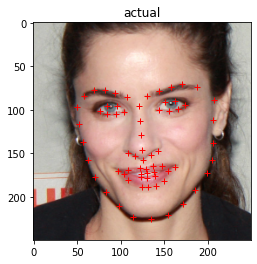

3.818702403111979
(68, 2)


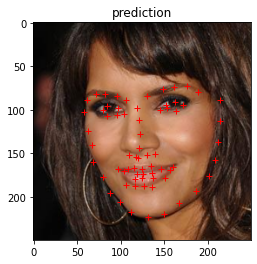

In [60]:
pred = model.predict(np.array([images[0]]))
print(pred.shape)
pred = pred * 250
pred = np.reshape(pred, (68,2))
plt.plot(pred[:, 0], pred[:, 1], '+r')
plt.title("prediction")
plt.imshow(images[0])
plt.show()

plt.plot(pts[0, ...][:, 0], pts[0, ...][:, 1], '+r')
plt.title("actual")
plt.imshow(images[0])
plt.show()

euclidDist = euclid_dist(pred, pts[0])

print(np.mean(euclidDist))

#show on test images
predT = model.predict(np.array([test["images"][25]]))
print(pred.shape)
predT = predT * 250
predT = np.reshape(predT, (68,2))
plt.plot(predT[:, 0], predT[:, 1], '+r')
plt.title("prediction")
plt.imshow(test["images"][25])
plt.show()

In [50]:
#get sunglasses for use
!wget -O sunglasses.png https://www.clipartmax.com/png/full/1-12975_sun-clipart.png

--2020-05-27 19:38:32--  https://www.clipartmax.com/png/full/1-12975_sun-clipart.png
Resolving www.clipartmax.com (www.clipartmax.com)... 70.36.99.235
Connecting to www.clipartmax.com (www.clipartmax.com)|70.36.99.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11890 (12K) [image/png]
Saving to: ‘sunglasses.png’

sunglasses.png      100%[===================>]  11.61K  --.-KB/s    in 0s      

2020-05-27 19:38:32 (199 MB/s) - ‘sunglasses.png’ saved [11890/11890]



## Sunglasses on Training image

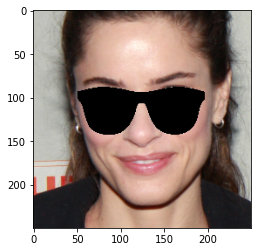

In [99]:
# Display sunglasses on top of the image in the appropriate place

# copy of the face image for overlay
image_copy = np.copy(images[0])

# top-left location for sunglasses to go
# 17 = edge of left eyebrow
x = int(pred[17, 0])-10
y = int(pred[17, 1])

# height and width of sunglasses
h = int(abs(pred[27,1] - pred[34,1]))
w = int(abs(pred[17,0] - pred[26,0]))+20

# read in sunglasses
sunglasses = cv.imread('./sunglasses.png', cv.IMREAD_UNCHANGED)
# resize sunglasses
new_sunglasses =  cv.resize(sunglasses, (w, h), interpolation = cv.INTER_CUBIC)

# get region of interest on the face to change
roi_colour = image_copy[y:y+h,x:x+w]

# find all non-transparent pts
ind = np.argwhere(new_sunglasses[:,:,3] > 0)


for i in range(3):
    roi_colour[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
# set the area of the image to the changed region with sunglasses
image_copy[y:y+h,x:x+w] = roi_colour

# display the result!
plt.imshow(image_copy)

## Sunglasses on Test image

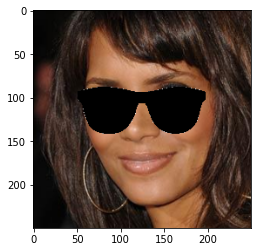

In [90]:
image2 = np.copy(test["images"][25])

# top-left location for sunglasses to go
# 17 = edge of left ey2ebrow2
x2 = int(predT[17, 0])-10
y2 = int(predT[17, 1])

# h2eigh2t and w2idth2 of sunglasses
h2 = int(abs(predT[27,1] - predT[34,1]))
w2 = int(abs(predT[17,0] - predT[26,0]))+20
# resize sunglasses
new2_sunglasses =  cv.resize(sunglasses, (w2, h2), interpolation = cv.INTER_CUBIC)

# get region of interest on th2e face to ch2ange
roi_colour2 = image2[y2:y2+h2,x2:x2+w2]

# find2 all non-transparent pts
ind2 = np.argwhere(new2_sunglasses[:,:,3] > 0)


for i in range(3):
    roi_colour2[ind2[:,0],ind2[:,1],i] = new2_sunglasses[ind2[:,0],ind2[:,1],i]    
# set th2e area of th2e image to th2e ch2anged region w2ith2 sunglasses
image2[y2:y2+h2,x2:x2+w2] = roi_colour2


# display2 th2e result!
plt.imshow(image2)

## Save and zip

Save the model and zip it so we can download it and use it later
Also save the predictions so we can use it later too

In [0]:
!mkdir weights
model.save_weights('./weights/currModel')

In [0]:
!zip -r weights.zip weights/

  adding: weights/ (stored 0%)


In [0]:
allPred = model.predict(images)

In [0]:
save_as_csv(allPred)